In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import tensorflow as tf
from dataclasses import dataclass
from datetime import timedelta

In [2]:
df = pd.read_csv("datasets/tsla_data.csv")
df.sort_values("date", inplace=True)
df = df[["close","date"]]
df.head()

,close,date
1256,15.12,2019-08-19
1255,15.06,2019-08-20
1254,14.72,2019-08-21
1253,14.81,2019-08-22
1252,14.09,2019-08-23


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
@dataclass
class G:
    TIME = np.array(df["date"])
    SERIES = np.array(df["close"])
    WINDOW_SIZE = 6
    BATCH_SIZE = 8
    SHUFFLE_BUFFER_SIZE = 250

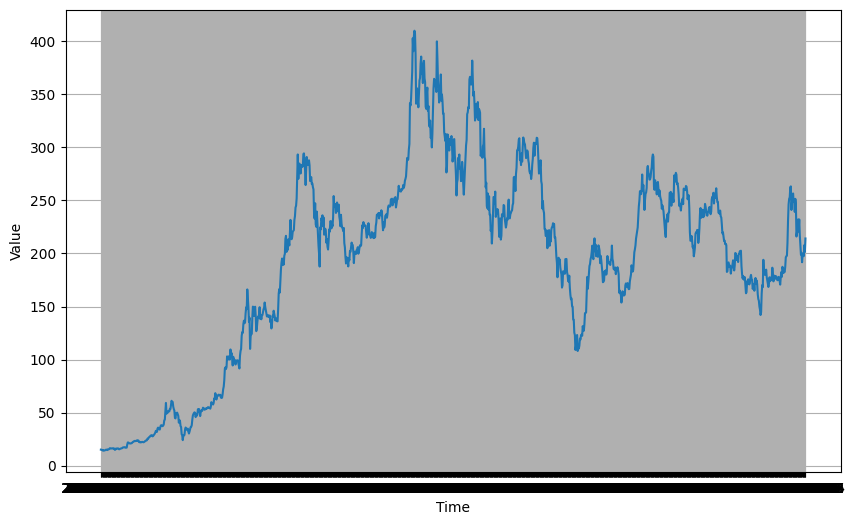

In [5]:
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [6]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

data = windowed_dataset(G.SERIES, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [7]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
                               ])

    return model

In [8]:
uncompiled_model = create_uncompiled_model()

for X, y in data.take(1):

    print(f"Testing model prediction with input of shape {X.shape}...")
    y_pred = uncompiled_model.predict(X)

y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f"Squuezed predicted y shape = {y_pred_shape}"
                                 f"whereas actual y shape = {y.shape}.")

print("Your current architecture is compatible with the windowed dataset!")

c:\Users\MEHMET\Desktop\stock_forecast\stenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing model prediction with input of shape (8, 6)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Your current architecture is compatible with the windowed dataset!


In [9]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = tf.keras.backend.get_value(self.model.optimizer.learning_rate)

In [10]:
def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    lr_logger = LearningRateLogger()

    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule, lr_logger])

    return history

In [11]:
lr_history = adjust_learning_rate(data)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 148.3675 - mae: 148.8675 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 2/100
 57/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.7860 - mae: 85.2859

C:\Users\MEHMET\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118.7038 - mae: 119.2034 - learning_rate: 1.1220e-04 - lr: 1.1220e-04
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73.3874 - mae: 73.8841 - learning_rate: 1.2589e-04 - lr: 1.2589e-04
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.9836 - mae: 85.4820 - learning_rate: 1.4125e-04 - lr: 1.4125e-04
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94.8646 - mae: 95.3641 - learning_rate: 1.5849e-04 - lr: 1.5849e-04
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 90.3656 - mae: 90.8636 - learning_rate: 1.7783e-04 - lr: 1.7783e-04
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98.0311 - mae: 98.5308 - learning_rate: 1.9953e-04 - lr: 1.9953e-04
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98.6880 - mae: 99.1863 - learning_rate: 2.2387e-04 - lr: 2.2387e-04
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 101.5233 - mae: 102.0220 - learning_rate: 2.51

In [12]:
def get_best_learning_rate(history):

    losses = history.history['loss']
    

    min_loss_epoch = losses.index(min(losses))
    

    best_lr = 1e-4 * 10**(min_loss_epoch / 20)
    
    return best_lr

In [13]:
best_lr = get_best_learning_rate(lr_history)

In [14]:
print(best_lr)

0.00012589254117941674


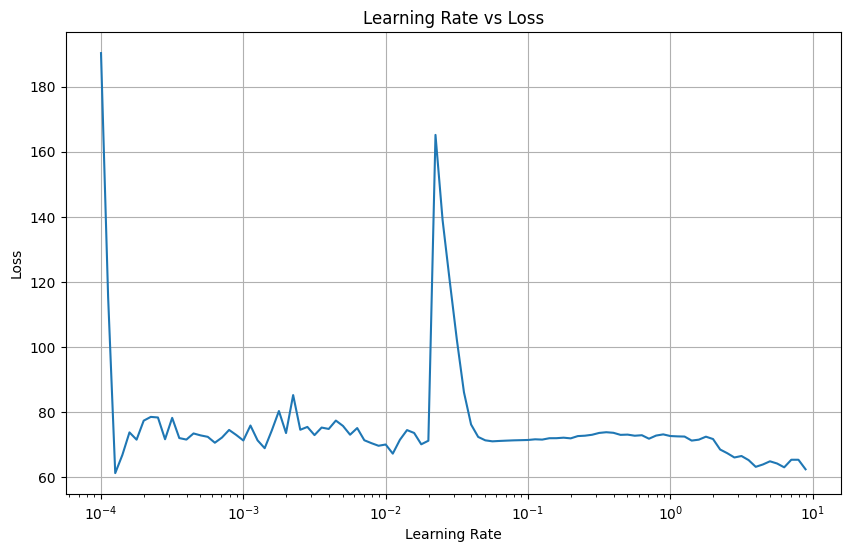

In [15]:
plt.figure(figsize=(10, 6))
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.grid(True)
plt.show()

In [16]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
                  metrics=["mean_absolute_error"])
    
    return model

In [17]:
model = create_model()


history = model.fit(data, epochs=20)

Epoch 1/20


c:\Users\MEHMET\Desktop\stock_forecast\stenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 149.6089 - mean_absolute_error: 150.1089
Epoch 2/20
 51/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79.5213 - mean_absolute_error: 80.0213

C:\Users\MEHMET\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 140.5911 - mean_absolute_error: 141.0911
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 136.3448 - mean_absolute_error: 136.8446
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 127.2429 - mean_absolute_error: 127.7410
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 119.3997 - mean_absolute_error: 119.8971
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 108.7845 - mean_absolute_error: 109.2807
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96.7181 - mean_absolute_error: 97.2157
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75.3729 - mean_absolute_error: 75.8540
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.8620 - mean_absolute_error: 59.3540
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.7943 - mean_absolute_error: 43.2781
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.1779 - mean_absolute_error: 31.6535
Epoch 12/

In [18]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
# Compute the forecast for all the series
lstm_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()



40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [20]:
lstm_forecast

array([ 13.505044,  13.38644 ,  13.32002 , ..., 197.24287 , 195.39253 ,
       201.1161  ], dtype=float32)